# Spis treści
1.1 [Import paczek](#Import-paczek)  
1.2 [Ładowanie danych treningowych](#Ladowanie-danych-treningowych)  
2.0 [Opis danych](#Opis-danych)  
3.0 [Trenowanie modelu](#Trenowanie-modelu)  
3.1 [Zrozumienie i interpretacja wyników](#Zrozumienie-i-interpretacja-wynikow)  
3.1.1 [Laying](#Laying)  
3.1.2 [Sitting](#Sitting)  
3.1.3 [Walking](#Walking)  
3.1.4 [Walking downstairs](#Walking-downstairs)  
3.1.5 [Walking upstairs](#Walking-upstairs)     
4.0 [Zastosowanie w biznesie](#Zastosowanie-w-biznesie)     
5.0 [Bibliografia](#Bibliografia)

## Import paczek

In [1]:
import pandas as pd             # obróbka danych
import numpy as np              # obróbka danych
import matplotlib.pyplot as plt # wizualizacja danych
import seaborn as sns           # wizualizacja danych
from random import shuffle
from plotnine import ggplot, geom_line, aes, stat_smooth, facet_wrap, theme_classic, ggtitle # wizualizacja danych

import shap # wizualizacja znaczenia cech

from sklearn.model_selection import train_test_split                    # podział danych na testowe i treningowe
from sklearn.inspection import plot_partial_dependence
from sklearn.feature_selection import VarianceThreshold                 # zmniejszenie wymiarowości danych
from sklearn.feature_selection import SelectKBest, mutual_info_classif  # zmniejszenie wymiarowości danych
from sklearn.metrics import confusion_matrix                            # analiza modelu
from sklearn.linear_model import LogisticRegression                     # baseline

import xgboost                                  # końcowy model
from xgboost import XGBClassifier               # końcowy model

import eli5
from eli5.sklearn import PermutationImportance # obliczanie istotności cech

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


## Ładowanie danych treningowych

In [2]:
train_data = pd.read_csv("../.data/final_train.csv")

# Czyszczenie danych oraz redukacja wymiarowości

In [3]:
train_data.head()

,Unnamed: 0,Activity,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyAccMean,gravity)","angle(tBodyGyroJerkMean,gravityMean)","angle(tBodyGyroMean,gravityMean)",energy-mean(),...,tGravityAccMag-energy(),tGravityAccMag-entropy(),tGravityAccMag-iqr(),tGravityAccMag-mad(),tGravityAccMag-max(),tGravityAccMag-mean(),tGravityAccMag-min(),tGravityAccMag-sma(),tGravityAccMag-std(),void()
0,0,STANDING,-1.574191,-0.805700,-2.453831,-1.861714,0.115517,-2.023369,3.125860,-9.474436,...,5.049130,3.272281,5.103018,-0.823302,3.063681,-0.928676,-1.007695,3.094236,1.669987,1.0
1,1,WALKING_UPSTAIRS,-1.568669,-0.612620,-2.488338,-1.751117,0.218134,0.280294,7.953403,-0.679894,...,4.565443,4.440779,3.288399,-2.689605,1.705341,-0.822617,-0.572410,-2.187890,-0.544652,2.0
2,2,LAYING,-1.548333,-0.139628,-2.380889,-1.915239,0.067613,-0.887342,6.007361,-11.906904,...,5.059609,2.296603,5.344174,-0.549843,3.272225,-0.940610,-1.031522,-2.071755,2.024442,3.0
3,3,WALKING,-1.574094,-0.793443,-2.449959,-1.842741,-0.195625,-0.950671,2.104353,-11.906121,...,4.860758,4.177535,3.950012,-0.322642,2.366287,-0.866937,-0.696431,1.863375,0.550414,2.0
4,4,LAYING,-1.548333,-0.139628,-2.380889,NaN,0.067613,-0.887342,6.007361,-11.970485,...,5.059609,2.296603,5.344174,-0.549843,3.272225,-0.940610,-1.031522,-2.102513,2.024442,3.0


Wszystkie dane pochodzą z akcelerometru (zdjęcie po lewej) i żyroskopu (zdjęcie po prawej). Są to odniesienia względem osi XYZ. Oprócz surowych danych z urządzenia znajdują się też wartości uzyskane dzięki wykorzystaniu szybkiej transformaty Fouriera (FFT).

<table><tr><td><img title='akcelerometr 'src='../zdjęcia/akcelerometr.png'></td><td><img title='żyroskop 'src='../zdjęcia/żyroskop.png'></td></tr></table>

Telefon przymocowany był w pozycji poziomej do pasa użytkownika.

<div style="text-align: center;">
<img title='pozycja' src='../zdjęcia/pozycja.png'>
</div>

Wykonajmy histogram wartości dla parametru "angle(X,gravityMean)" (wykorzystaliśmy bibliotekę SHAP żeby zidentyfikować go jako najistotniejszy parametr dla modelu).

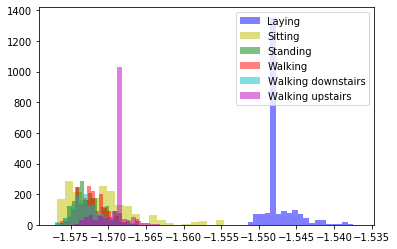

In [4]:
laying = train_data.loc[train_data.Activity == "LAYING", "angle(X,gravityMean)"]
sitting = train_data.loc[train_data.Activity == "SITTING", "angle(X,gravityMean)"]
standing = train_data.loc[train_data.Activity == "STANDING", "angle(X,gravityMean)"]
walking = train_data.loc[train_data.Activity == "WALKING", "angle(X,gravityMean)"]
walking_downstairs = train_data.loc[train_data.Activity == "WALKING_DOWNSTAIRS", "angle(X,gravityMean)"]
walking_upstairs = train_data.loc[train_data.Activity == "WALKING_UPSTAIRS", "angle(X,gravityMean)"]

kwargs = dict(alpha=0.5, bins=20)

plt.hist(laying, **kwargs, color="b", label="Laying")
plt.hist(sitting, **kwargs, color="y", label="Sitting")
plt.hist(standing, **kwargs, color="g", label="Standing")
plt.hist(walking, **kwargs, color="r", label="Walking")
plt.hist(walking_downstairs, **kwargs, color="c", label="Walking downstairs")
plt.hist(walking_upstairs, **kwargs, color="m", label="Walking upstairs")

plt.legend()

Widać, że możemy uzależnić aktywność leżenia wyłączne od tej cechy. Jeżeli dla danego rekordu jej wartość jest wyższa niż -1.553 to automatycznie przypisujemy mu kategorię "LAYING". Dzięki temu przy trenowaniu modelu nie musimy uwzględniać tej klasy, dzięki czemu **nasz model jest dużo lżejszy**, wykonywał mniej operacji i tym samym - będzie **pobierał mniej energii** po umieszczeniu na urządzeniu docelowym.

In [5]:
train_data.drop(train_data[train_data['angle(X,gravityMean)'] > -1.553].index, axis=0, inplace=True)

In [6]:
train_data

,Unnamed: 0,Activity,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyAccMean,gravity)","angle(tBodyGyroJerkMean,gravityMean)","angle(tBodyGyroMean,gravityMean)",energy-mean(),...,tGravityAccMag-energy(),tGravityAccMag-entropy(),tGravityAccMag-iqr(),tGravityAccMag-mad(),tGravityAccMag-max(),tGravityAccMag-mean(),tGravityAccMag-min(),tGravityAccMag-sma(),tGravityAccMag-std(),void()
0,0,STANDING,-1.574191,-0.805700,-2.453831,-1.861714,0.115517,-2.023369,3.125860,-9.474436,...,5.049130,3.272281,5.103018,-0.823302,3.063681,-0.928676,-1.007695,3.094236,1.669987,1.0
1,1,WALKING_UPSTAIRS,-1.568669,-0.612620,-2.488338,-1.751117,0.218134,0.280294,7.953403,-0.679894,...,4.565443,4.440779,3.288399,-2.689605,1.705341,-0.822617,-0.572410,-2.187890,-0.544652,2.0
3,3,WALKING,-1.574094,-0.793443,-2.449959,-1.842741,-0.195625,-0.950671,2.104353,-11.906121,...,4.860758,4.177535,3.950012,-0.322642,2.366287,-0.866937,-0.696431,1.863375,0.550414,2.0
5,5,SITTING,-1.575809,-0.640703,-2.460251,-1.849850,0.174633,-0.151900,3.562269,-5.978664,...,5.012806,3.784507,4.524738,-6.202087,2.763802,-0.913074,-0.991923,2.783184,0.946387,2.0
7,7,STANDING,-1.567323,-0.857850,-2.490082,-1.832982,0.112276,-0.738710,7.961757,-9.302665,...,5.060179,2.089889,5.362029,-0.555530,3.272104,-0.942724,-1.030745,-2.238799,2.010097,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11080,11080,WALKING_DOWNSTAIRS,-1.575492,-0.614487,-2.452436,-1.732651,-0.418138,1.768320,5.163003,-4.868354,...,4.044203,4.604386,2.021879,-3.945744,1.298908,-0.769566,-0.737230,-1.986261,-1.792696,1.0
11081,11081,WALKING_UPSTAIRS,-1.568669,-0.612620,-2.488338,-1.751117,0.218134,0.280294,7.953403,-0.679894,...,4.565443,4.440779,3.288399,-2.689605,1.705341,-0.822617,-0.572410,3.534816,-0.544652,2.0
11083,11083,WALKING_UPSTAIRS,-1.569815,-0.794940,-2.482325,-1.784151,0.021844,-0.740329,8.005261,-11.916107,...,4.453514,4.302852,2.979961,-6.032382,1.853029,-0.802817,0.041975,3.427548,-0.075184,1.0
11084,11084,WALKING_DOWNSTAIRS,-1.574768,-0.752847,-2.449529,-1.737755,-0.189761,-0.454246,8.054443,-5.611277,...,4.615939,4.443277,3.208597,-6.200222,1.675269,-0.828934,-0.877004,3.385405,-0.383217,3.0


Usuwamy zmienną zawierającą id obserwacji o nazwie `Unnamed: 0` oraz zmienną `subject`, która opisuje id obserwowanej osoby. Zastosowanie tych zmiennych skutkowałoby przeuczeniem modelu.

In [7]:
train_data.drop(["Unnamed: 0", "subject"], axis='columns', inplace=True)

Usuwamy cechy z niską wariancją, które nie są istotne dla predykcji.

In [8]:
train_data

,Activity,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyAccMean,gravity)","angle(tBodyGyroJerkMean,gravityMean)","angle(tBodyGyroMean,gravityMean)",energy-mean(),"fBodyAcc-bandsEnergy()-1,16",...,tGravityAccMag-energy(),tGravityAccMag-entropy(),tGravityAccMag-iqr(),tGravityAccMag-mad(),tGravityAccMag-max(),tGravityAccMag-mean(),tGravityAccMag-min(),tGravityAccMag-sma(),tGravityAccMag-std(),void()
0,STANDING,-1.574191,-0.805700,-2.453831,-1.861714,0.115517,-2.023369,3.125860,-9.474436,3.622600,...,5.049130,3.272281,5.103018,-0.823302,3.063681,-0.928676,-1.007695,3.094236,1.669987,1.0
1,WALKING_UPSTAIRS,-1.568669,-0.612620,-2.488338,-1.751117,0.218134,0.280294,7.953403,-0.679894,2.512880,...,4.565443,4.440779,3.288399,-2.689605,1.705341,-0.822617,-0.572410,-2.187890,-0.544652,2.0
3,WALKING,-1.574094,-0.793443,-2.449959,-1.842741,-0.195625,-0.950671,2.104353,-11.906121,3.355701,...,4.860758,4.177535,3.950012,-0.322642,2.366287,-0.866937,-0.696431,1.863375,0.550414,2.0
5,SITTING,-1.575809,-0.640703,-2.460251,-1.849850,0.174633,-0.151900,3.562269,-5.978664,3.611319,...,5.012806,3.784507,4.524738,-6.202087,2.763802,-0.913074,-0.991923,2.783184,0.946387,2.0
7,STANDING,-1.567323,-0.857850,-2.490082,-1.832982,0.112276,-0.738710,7.961757,-9.302665,3.623865,...,5.060179,2.089889,5.362029,-0.555530,3.272104,-0.942724,-1.030745,-2.238799,2.010097,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11080,WALKING_DOWNSTAIRS,-1.575492,-0.614487,-2.452436,-1.732651,-0.418138,1.768320,5.163003,-4.868354,0.507122,...,4.044203,4.604386,2.021879,-3.945744,1.298908,-0.769566,-0.737230,-1.986261,-1.792696,1.0
11081,WALKING_UPSTAIRS,-1.568669,-0.612620,-2.488338,-1.751117,0.218134,0.280294,7.953403,-0.679894,2.512880,...,4.565443,4.440779,3.288399,-2.689605,1.705341,-0.822617,-0.572410,3.534816,-0.544652,2.0
11083,WALKING_UPSTAIRS,-1.569815,-0.794940,-2.482325,-1.784151,0.021844,-0.740329,8.005261,-11.916107,2.644861,...,4.453514,4.302852,2.979961,-6.032382,1.853029,-0.802817,0.041975,3.427548,-0.075184,1.0
11084,WALKING_DOWNSTAIRS,-1.574768,-0.752847,-2.449529,-1.737755,-0.189761,-0.454246,8.054443,-5.611277,2.473134,...,4.615939,4.443277,3.208597,-6.200222,1.675269,-0.828934,-0.877004,3.385405,-0.383217,3.0


In [9]:
temp_data = train_data.copy(deep=False)
temp_data.Activity = train_data.Activity.astype("category").cat.codes

sel = VarianceThreshold(threshold=.15)
vt = sel.fit_transform(temp_data)
cols = [train_data.columns[ix] for ix in sel.get_support(indices=True)]
train_data = train_data[train_data.columns[sel.get_support(indices=True)]]

W danych znajduje się wiele brakujących wartości. Aby poprawić jakoś zbioru danych zdecydowaliśmy się je uzupełnić. Dla każdej z aktywności, dla każdej z kolumn obliczamy średnią $\mu$ oraz wartości odchylenia standardowego $\sigma$. Następnie, każdą z brakujących ($m_{i,j}$) wartości estymujemy wartością pochodzącą z odpowiedniego dla danej kolumny i aktywności rozkładu $\widehat{m}_{i,j} \thicksim\ \mathcal{N}(\mu,\,\sigma^{2})$. Takie podejście pozwala na powiększenie zbioru użytecznych danych przy jednoczesnym zachowaniu wariancji danych, co zapobiega przeuczeniu modelu.

In [10]:
class imputer:
    def __init__(self, df, cols):
        self.__generator = np.random.default_rng()
        self.__values = dict()
        for col in cols:
            self.__values[col] = [df[col].mean(
                skipna=True), df[col].std(skipna=True)]

    def fill(self, column_name):
        mean = self.__values[column_name][0]
        sd = self.__values[column_name][1]
        return self.__generator.normal(loc=mean, scale=sd)

final_data = pd.DataFrame()
for act in ['SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']:

    act_data = train_data[train_data["Activity"] == act]
    imp = imputer(act_data, cols[1:])
    for col in cols[1:]:
        act_data[col] = act_data[col].apply(
            lambda x: imp.fill(col) if x != x else x)

    if final_data.shape == (0, 0):
        final_data = pd.DataFrame(act_data)
    else:
        final_data = pd.concat([final_data, act_data])
train_data = final_data.copy(deep=False)
y = train_data["Activity"]
X = train_data.iloc[:,2:]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
mi = []
for feature, importance in zip(X.columns.values.tolist(), mutual_info_classif(X, y)):
    mi.append([feature, importance])
mi.sort(key=lambda x: x[1], reverse=True)

In [13]:
range_ = list(range(2, 30)) + list(range(40, 220, 10))
results = []
for features_n in range_:
    mi_new = mi[:features_n]
    mi_new = [x[0] for x in mi_new]
    X_new = X.loc[:, mi_new]
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25, random_state=2)
    model = XGBClassifier(tree_method="approx", verbosity=0).fit(X_train, y_train)
    results.append([features_n, model.score(X_test, y_test)])

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


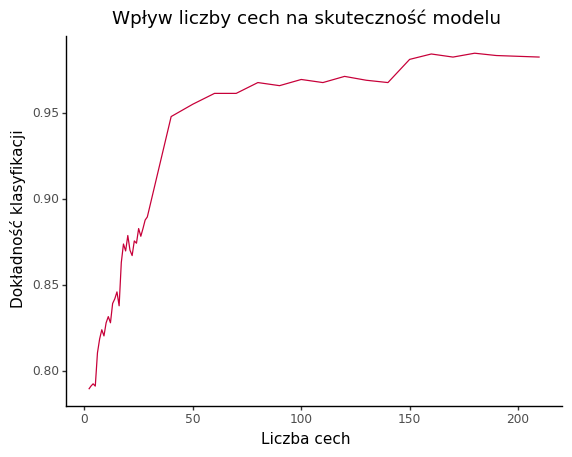

<ggplot: (8733684430321)>

In [14]:
features_to_accuracy = results

df = pd.DataFrame(data=features_to_accuracy, columns = ['Liczba cech', 'Dokładność klasyfikacji']) 

(ggplot(df, aes('Liczba cech', 'Dokładność klasyfikacji'))
 + ggtitle("Wpływ liczby cech na skuteczność modelu")
 + geom_line(colour="#C70039")
 + theme_classic())

Widać że dla modelu z przynajmniej 50 cechami, accuracy zmienia się nieznacznie.

# Trenowanie modelu

Po wyczyszczeniu danych i zredukowaniu wymiarów, dobieraliśmy model, który jeszcze bez parametryzacji dawał najbardziej obiecujące wyniki. Do ewaluacji każdego z modelów zastosowaliśmy walidację krzyżową K-Fold. Dane zostały podzielone na 10 części. Następnie model 10-krotnie był uczony, za każdym razem używając 10 innych części danych wejściowych. Pozostała część służyła do obliczania accuracy, to znaczy wartości opisującej stosunek liczby prawidłowo przewidzianych klas do wszyskich przypadków:
$ Accuracy = \frac{Liczba\_prawidłowych\_przewidywań}{Łączna\_liczba\_wysztkich\_przewidywań} $. Na końcu, dla każdego modelu obliczyliśmy średnią wartość accuracy z 10 iteracji: $ score_{model} = \frac{1}{10} \sum_{i=1}^{10}accuracy_i $. Dla minimalizacji losowości, dla wszystkich modeli dane były dzielone oraz model był uczony przy tym samym seed.


**Średnie accuracy z k-fold dla k=10**:

XGBoost:
- `XGBClassifier`:
    - `exact` - 0.9871061134514049
    - `approx` - 0.9881153337057672
    - `gpu_hist` - 0.9868822756715133
    - `hist` - 0.987667029034742
- `XGBRFClassifier`:
    - `exact` - 0.9557119526103083
    - `approx` - 0.9561600056368367
    - `gpu_hist` - 0.9328399842973834
    - `hist` - 0.9551505337379776

CatBoost
 - `CatBoostClassifier` - 0.9880031002602007

scikit-learn:
- `RandomForestClassifier` - 0.9790336096389908
- `LogisticRegression` - 0.9473031259279392
- `ExtraTreeClassifier` - 0.9080621863880458
- `DecisionTreeClassifier` - 0.9414734036931348
- `BernoulliNB` - 0.7154376349443614
- `GradientBoostingClassifier` - 0.9807156014555117

Po otrzymaniu tych wyników zdecydowaliśmy się na rozwijanie modelu XGBClassifier. Model ten wyróżnia również szybkość działania oraz dbałość o możliwe zmniejszanie złożoności, co stanowiło dodatkowe zalety, potwierdzające słuszność naszego wyboru. Dodatkowo niezwykłym atutem naszego modelu jest jego wytłumaczalność - w przeciwieństwie do głębokich sieci neuronowych możemy **prosto zwizualizować jego działanie**. Dzięki temu za pomocą wyciągniętej przez model wiedzy, zadając **nie więcej niż pięć pytań** (taka jest głębokość naszego drzewa) dokonujemy decyzji o klasie - tym samym efektywne zastosowanie modelu nie wymaga nawet urządzenia elektronicznego. Każda osoba posiadająca wydruk naszego drzewa jest w stanie skutecznie zakwalifikować nowy rekord.

Po próbowaniu różnych wartości parametrów dla modelu XGBClassifier zdecydowaliśmy się na następujące wartości:
- `tree_method='approx'`
- `eval_metric='merror'`

In [15]:
model = xgboost.XGBClassifier(tree_method='approx', eval_metric='merror', verbosity=0).fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


In [16]:
y_pred = model.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']))

,0,1,2,3,4
0,500,17,0,0,0
1,10,479,0,0,0
2,0,0,451,2,0
3,0,0,5,330,2
4,0,0,2,1,431


Dane, które uzyskujemy dzięki policzeniu confusion matrix wskazują, że najczęściej mylone były:
- siedzenie ze staniem - w obu sytuacjach człowiek się nie przemieszcza i znajduje się w pozycji pionowej, ruch wokół osi Y ciała odczytywany z żyroskopu może wskazywać na stanie
- chodzenie z wchodzeniem po schodach - chociaż w większości przypadków odczyt przyspieszenia na osi Y odczytywany z akcelerometru powinien wykluczać pomyłkę, naturalne nierówności terenu mogą błędnie sugerować wchodzenie po schodach
- wchodzenie oraz schodzenie po schodach - chociaż teoretycznie czynności te są trudne do pomylenia - różnią się szybkością wykonywania, odczytami z akcelerometru, innym chodem człowieka, a więc innymi odczytami z żyroskopu, tu również zdarzały się pomyłki; były najprawdopodobniej związane z podobnym chodem w obu kierunkach lub niejednoznacznym ruchem, tzn. ktoś mógł wejść po schodach i od razu zejść.

Zdecydowanie najczęściej mylone są siedzenie i stanie, wynik ten można by skorygować obserwując, czy nastąpiło siadanie lub wstawanie, a więc gwałtowny, krótki ruch wzdłuż osi Y zanim została wykonana mierzona czynność. Pomyłki związane ze schodami są znacznie rzadsze i trudniejsze do jednoznacznej korekty.

W celu dalszego zredukowania wymiarowości modelu, wyliczamy permutation importance dla cech z których korzysta. 

In [17]:
perm = PermutationImportance(model).fit(X_test, y_test)
imp = list(zip(X_test.columns.tolist(), perm.feature_importances_))
features = []
for feature in imp:
    if feature[1] > 0:
        features.append(feature[0])

Widzimy że model został zredukowany do jedynie X cech. Jest to istotne dla naszego problemu ponieważ chcemy zminimalizować potrzebną moc zasobową. Dzięki temu nasz model będzie wykonywał się w **krótszym czasie** i będzie potrzebował **mniej energi**.

Na ograniczonym zbiorze cech ponownie wyuczamy model:

In [18]:
features = ['fBodyAccJerk-mad()-Z',
            'fBodyAccMag-meanFreq()',
            'tBodyAcc-arCoeff()-X,1',
            'tGravityAcc-entropy()-Y',
            'fBodyGyro-bandsEnergy()-1,16.2',
            'tBodyGyroJerk-iqr()-X',
            'fBodyAcc-kurtosis()-X',
            'fBodyAccJerk-mean()-Z',
            'fBodyAccMag-mean()',
            'fBodyBodyGyroJerkMag-skewness()',
            'tBodyAcc-min()-Z',
            'tBodyGyro-sma()',
            'tBodyGyroJerk-arCoeff()-Z,2',
            'tBodyGyroJerkMag-mad()',
            'tGravityAccMag-arCoeff()1',
            'fBodyAccMag-energy()',
            'fBodyAccJerk-kurtosis()-Z',
            'fBodyAccJerk-skewness()-X',
            'fBodyGyro-mean()-Z',
            'tBodyAcc-max()-Z',
            'tBodyAccJerk-arCoeff()-Z,3',
            'tBodyGyro-arCoeff()-X,4',
            'tBodyGyro-max()-Z',
            'tGravityAcc-mean()-X',
            'tGravityAcc-mean()-Z',
            'fBodyAccJerk-bandsEnergy()-1,16.1',
            'fBodyAccJerk-sma()',
            'fBodyAccMag-entropy()',
            'fBodyBodyGyroJerkMag-sma()',
            'fBodyGyro-entropy()-Y',
            'tBodyGyro-min()-Y',
            'fBodyBodyGyroJerkMag-max()',
            'angle(tBodyGyroMean,gravityMean)',
            'tBodyAccJerk-iqr()-Y',
            'tBodyGyroJerk-correlation()-X,Z',
            'tGravityAcc-arCoeff()-Z,4',
            'tBodyGyroJerk-std()-X',
            'fBodyBodyAccJerkMag-max()',
            'tBodyAcc-sma()',
            'tBodyAccMag-mean()',
            'tBodyGyro-correlation()-X,Y',
            'fBodyAcc-std()-Y',
            'fBodyAccJerk-meanFreq()-X',
            'tBodyGyro-iqr()-Y',
            'tGravityAccMag-arCoeff()4',
            'fBodyBodyAccJerkMag-skewness()',
            'tGravityAcc-min()-Z',
            'fBodyGyro-bandsEnergy()-1,8.2',
            'fBodyAcc-std()-X',
            'tBodyAccMag-energy()',
            'fBodyAcc-bandsEnergy()-9,16',
            'fBodyGyro-kurtosis()-Z',
            'fBodyAccJerk-std()-Z',
            'tBodyAccJerk-min()-Y',
            'tBodyAccMag-mad()',
            'tBodyGyro-mad()-X',
            'fBodyGyro-max()-X',
            'tGravityAcc-arCoeff()-Y,4',
            'tBodyAcc-entropy()-Y',
            'fBodyAcc-bandsEnergy()-1,16',
            'fBodyAccJerk-meanFreq()-Z',
            'tBodyAcc-std()-Z',
            'tGravityAcc-max()-X',
            'tGravityAcc-max()-Z',
            'tBodyGyro-iqr()-Z',
            'fBodyAcc-max()-Y',
            'fBodyAcc-sma()',
            'fBodyAccJerk-bandsEnergy()-1,8',
            'fBodyGyro-skewness()-Z',
            'fBodyAccMag-mad()',
            'fBodyGyro-mad()-X',
            'tGravityAcc-energy()-Y',
            'tGravityAcc-arCoeff()-Z,3',
            'tBodyAcc-max()-X',
            'tBodyAccJerk-max()-Z',
            'tBodyAccJerk-entropy()-X',
            'fBodyGyro-maxInds-Z',
            'fBodyAccMag-std()',
            'tBodyGyro-iqr()-X',
            'tBodyGyro-max()-X',
            'tGravityAcc-mean()-Y']

Widzimy że model został zredukowany do jedynie X cech. Jest to istotne dla naszego problemu ponieważ chcemy zminimalizować potrzebną moc zasobową. Dzięki temu nasz model będzie wykonywał się w **krótszym czasie** i będzie potrzebował **mniej energi**.

Na ograniczonym zbiorze cech ponownie wyuczamy model:

In [19]:
y = train_data["Activity"]
X = train_data.loc[:, features]
X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.25, random_state=42)

model = xgboost.XGBClassifier(tree_method="approx", verbosity=0).fit(X_train, y_train)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


In [20]:
model.score(X_test, y_test)

0.9852017937219731

Możemy zaobserwować, że mimo redukcji wymiarów **accuracy** naszego modelu nadal jest **bardzo wysokie**. Wyróżnia to nasz model, gdyż udało nam się nie tylko znacznie go uprościć, ale również nie utracić dokładności jego działania, która jest **prawie bezbłędna**.

## Zrozumienie i interpretacja wyników

Do interpretacji tego, jak działa nasz model, wykorzystaliśmy bibliotekę SHAP. Pozwala ona na utworzenie prostych wizualizacji, pokazujących które wartości są najistotniejsze dla wytrenowanego modelu.

In [21]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

Na początku wykonujemy wykres istotności cech dla wszystkich klas.

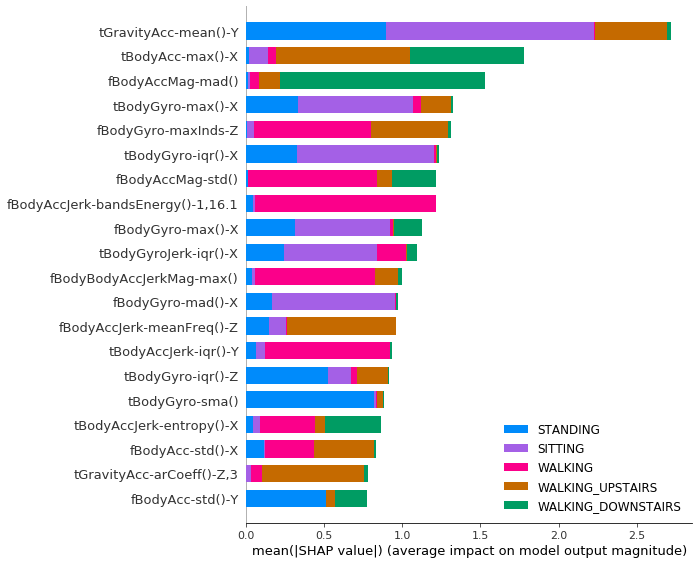

In [22]:
shap.summary_plot(shap_values, X_test, class_names=model.classes_)

Możemy z niego wyczytać, że najważniejszymy cechami dla określenia pozycji osoby są tGravityAcc-mean()-Y (głównie dla siedzenia i stania) oraz tBodyAcc-max()-X (głównie dla wchodzenia i schodzenia po schodach). Dokładniejsza analiza powodu, dla którego akurat te cechy są istotne znajduje się poniżej.

Następnie interpretujemy, które cechy są istotne do rozpoznania danej cechy i dlaczego:

### Laying

Klasa "laying" nie stanowiła części modelu, jako że klasyfikacja do tej klasy uzależniona była wyłącznie od tego, czy wartość cechy "angle(X,gravityMean)" była wyższa od -1.553 (a więc czy telefon był położony) i mogła zostać dokonana przed wykorzystaniem modelu. Zmniejszało do liczbę koniecznych operacji, a co za tym idzie, zużycie energii elektrycznej przez procesor.

### Sitting

Klasa "sitting" jest zależna przede wszystkim od:
* rozstępu ćwiartkowego wartości sygnału żyroskopu przetworzonego dla osi X
* maksymalnej wartości sygnału żyroskopu przetworzonego dla osi X
* średniej wartości przyspieszenia liniowego ciała względem osi Y

Znaczenie ma położenie telefonu względem osi X, co mierzone jest żyroskopem, a więc ruch względem osi pionowej użytkownika. Możemy to interpretować jako pewne "kręcenie się" w miejscu. Istotne są również odczyty akcelerometru względem osi Y - co jest skorelowane z odczytami z żyroskopu i oznacza pewne ruchy w miejscu, np. poprawianie pozycji.

<div><img title='sitting' src='../zdjęcia/sitting.png'></div>

### Standing

Klasa "standing" jest zależna przede wszystkim od:
- prostej średniej kroczącej wartości akcelerometru po przetworzeniu sygnału szybką transformatą fouriera
- rozstępu ćwiartkowego wartości sygnału żyroskopu przetworzonego dla osi Y
- średniej wartości przyspieszenia liniowego ciała względem osi Y

W przypadku stania największy wpływ na podjęcie decyzji mają ogólne odczyty z akcelerometru oraz żyroskopu w kontekście osi Y. Jak mogliśmy zauważyć przy confusion matrix oraz wykresów pokazujących znaczenie cech dla danych aktywności, klasa "standing" i "sitting" mają podobne "wymagania". Jednak podczas stania osoba mniej się "buja" ale ma większą swobodę przy obracaniu się.

<div><img title='standing' src='../zdjęcia/standing.png'></div>

### Walking

W przypadku klasy "walking" wyraźnie największy wpływ na zaklasyfikowanie danego wiersza ma: 
* zryw przyspieszenia akcelerometru
* maksymalna wartość wielkości euklidesowej zrywu przyspieszenia ciała przetworzonego szybką transformatą fouriera
* zmiana odczytów żyroskopu względem osi Z.

Możemy wywnioskować, że istotny jest ruch odbierany przez akcelerometr oraz pewne bujanie tylko w osi Z

<div><img title='walking' src='../zdjęcia/walking.png'></div>

### Walking downstairs

Klasa "Walking downstairs" jest mocno uzależnione od przyspieszenia odbieranego akcelerometrem, czyli ruchu, przyspieszenia względem osi X, co wynika z ruchu do dołu. Skupiamy się tu na szybkości użytkownika. Jest to najszybszy rodzaj zmieniania pozycji wśród aktywności, dzięki poruszaniu się "z przyśpieszeniem grawitacyjnym".

<div><img title='walking downstairs' src='../zdjęcia/walking_downstairs.png'></div>

### Walking upstairs

Klasa "walking upstairs" jest zależna przede wszystkim od maksymalnej wartości sygnału akceleratora przetworzonego osi X. Informacja ta przekazuje nam, że użytkownik przemieszcza się w górę. 

Ważny jest też odczyt żyroskopu i akceleratora względem osi Z ze względu na energiczne i niejednostajne ruchy do przodu podczas wchodzenia.

<div><img title='walking upstairs'src='../zdjęcia/walking_upstairs.png'></div>

# Zastosowanie w biznesie

Model może się przydać do różnych zastosowań, między innymi do:
* Smart Home
    * Wyłączanie światła w domu za pomocą lokalizacji i sprawdzenia, czy osoba schodzi po schodach.
* Monitorowania aktywności fizycznej - komunikaty typu "Rusz się!" kiedy użytkownik pozostaje za długo w spoczynku, podsumowanie czasu aktywności
    * Budzenie podczas zaśnięcia podczas pracy/prowadzenia samochodu.
        * Jeśli mamy telefon połączony z opaską/smartwatchem, możemy sprawdzić puls osoby, 
        * By polepszyć zdrowie użytkownika sprawdzamy, czy nie zasnął w pozycji niezdrowej dla jego ciała(siedzącej np. przed komputerem podczas hackathonu). Możemy wtedy obudzić użtkownika.
* Monitorowanie osób starszych - możliwość reakcji, w przypadku gwałtownej zmiany pozycji, która może wskazywać na niebezpieczeństwo.
Stworzone przez nas rozwiązanie 

# Bibliografia


1. [Energy Efficient Smartphone-Based Activity Recognition using Fixed-Point Arithmetic D. Anguita, A. Ghio, L. Oneto, X. Parra, Jorge Luis Reyes-Ortiz 2013](https://www.semanticscholar.org/paper/Energy-Efficient-Smartphone-Based-Activity-using-Anguita-Ghio/ed2cd4d99795a83a429d733e5cae5fab2dfb868f)       
1. [Human Activity Recognition Using Smartphones Dataset](http://rstudio-pubs-static.s3.amazonaws.com/24009_c068b79c74ae4fec8913fc0bf7a8b451.html)     
1. [Human Activity Recognition with Smartphones - Recordings of 30 study participants performing activities of daily living](https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones)     
1. [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/treemethod.html)  
1. [SHAP documentation](https://github.com/slundberg/shap)